# Team Ernst Engel Food Demand Notebook
In this notebook, we examine a system of demands for various food products, and examine heterogeneity in household consumption.

In [143]:
import pandas as pd
import numpy as np
from cfe import Regression
import warnings

In [145]:
%run nutritional_adequacy.ipynb

## Data Processing

In [316]:
country = 'uganda'
year_range = '2019-20'
food_nutrients, food_prices, hh_chars, expenditures, hhc_sub, fp_sub, food_cols, fp_sub_avgs = get_data(country, year_range)

In [318]:
warnings.filterwarnings("ignore")
x = expenditures
x.columns.name = 'j'
x = x.T.groupby('j').sum().T
x = x.replace(0,np.nan)

y = np.log(x.set_index(['i','t','m']))

p = fp_sub
p.columns.name = 'j'

d = hhc_sub.copy()
# d.reset_index(inplace = True)
d.columns.name = 'k'
d.set_index(['i','t','m'],inplace=True)

## Estimation
Recall the model put forth in lecture: <br>
Let $y_{i}^j$ be log expenditures on food $j$ by household $i$ at a particular time.  We want to estimate a regression that takes the form
$$
      y^j_{i} = A^j(p) + \gamma_j'd_i + \beta_j w_i + \zeta^j_i.
$$

In [321]:
y = y.stack()

d = d.stack()

assert y.index.names == ['i','t','m','j']
assert d.index.names == ['i','t','m','k']

result = Regression(y = y,d = d)

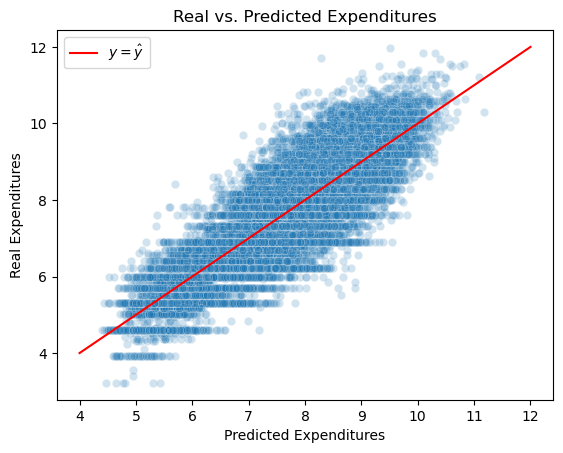

In [323]:
%matplotlib inline
plot_df = pd.DataFrame({'y' : y,'yhat' : result.get_predicted_log_expenditures()})

sns.scatterplot(data = plot_df, x = 'yhat', y = 'y', alpha = 0.2)
# plot_df.plot.scatter(x = 'yhat',y = 'y');

dummy_x = np.linspace(4, 12, 77)

### Overlay y = x line
plt.plot(dummy_x, dummy_x, color='red', label = r'$y = \hat{y}$')

plt.xlabel(r'Predicted Expenditures')
plt.ylabel(r'Real Expenditures')
plt.title('Real vs. Predicted Expenditures')
plt.legend()

plt.show()

## Parameters

### (Relative) Income Elasticity

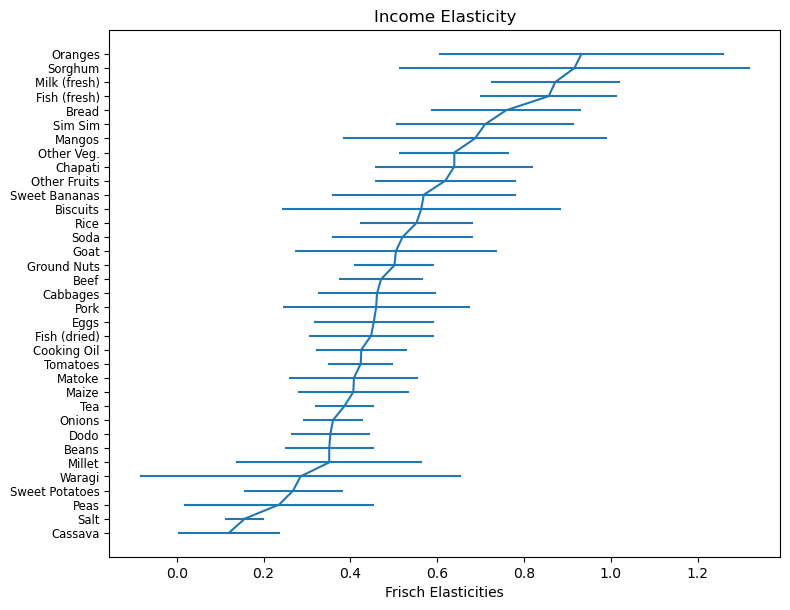

In [326]:
ax = result.graph_beta()
plt.title('Income Elasticity')
plt.show();

### Welfare

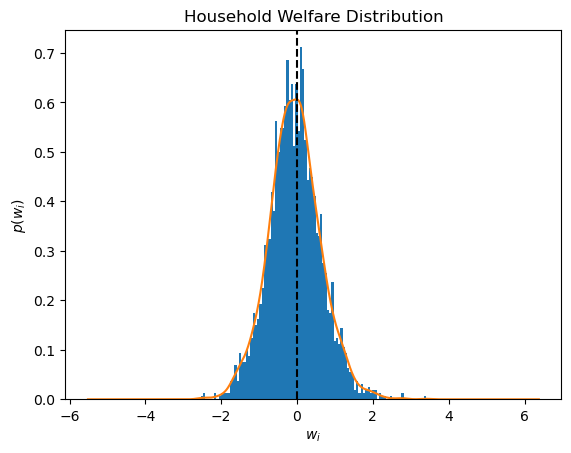

In [328]:
ax = result.get_w().plot.hist(bins = 100, density = True)
result.get_w().plot.kde(ax=ax)
plt.axvline(x = 0, color = 'black', linestyle = '--')
plt.ylabel(r'$p(w_{i})$')
plt.xlabel(r'$w_{i}$')
plt.title('Household Welfare Distribution')
plt.show();

## Demand and Utility

### Budgets

In [331]:
xhat = result.predicted_expenditures()

xbar = xhat.groupby(['i','t','m']).sum()

### Reference budget
xref = xbar.quantile(0.5)  # 0.5 ==> median

### Reference Prices

In [339]:
### Prices per kilogram:
pbar = p.mean()
pbar = pbar[result.beta.index] # Only use prices for goods we can estimate

#Finally, define a function to change a single price in the vector $p$:
def change_price(p0,p=pbar,j='Millet'):
    """
    Change price of jth good to p0, holding other prices fixed.
    """
    p = p.copy()
    p.loc[j] = p0
    return p

In [373]:
food_product = 'Millet'  # Good we want demand curve for

def plot_demands(food_product):
    # Vary prices from 50% to 200% of reference.
    scale = np.linspace(.5,2,20)

    # Demandfor household at median budget
    plt.plot([result.demands(xref, change_price(pbar[food_product] * s, pbar))[food_product] for s in scale], 
             scale, label = 'Median')

    # Demand for household at 25% percentile
    plt.plot([result.demands(xbar.quantile(0.25), change_price(pbar[food_product] * s, pbar))[food_product] for s in scale], 
             scale, label = '25th Percentile')

    # Demand for household at 75% percentile
    plt.plot([result.demands(xbar.quantile(0.75), change_price(pbar[food_product] * s, pbar))[food_product] for s in scale], 
             scale, label = '75th Percentile')

    plt.title(f"Demand of {food_product}")
    plt.ylabel(f"Price (relative to base of {pbar[food_product]:.2f})")
    plt.xlabel(f"Quantity")
    plt.legend()
    plt.show();

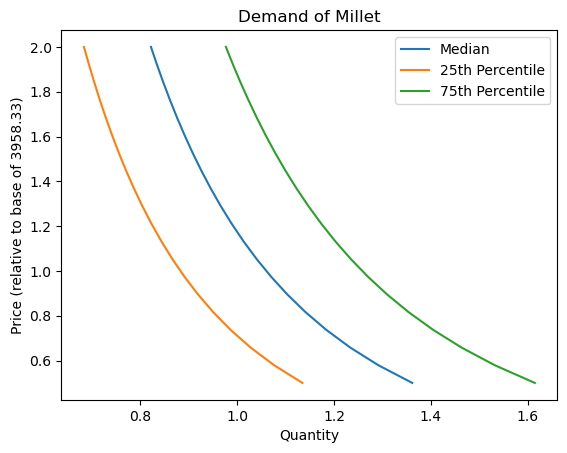

In [375]:
plot_demands(food_product)